# Extraction of tangential interface velocity

The aim is to extract the tangential interface velocity from pseudo 3D (axis-symmetric 2D) VoF simulations. The interface velocity is then used to create a more realistic velocity boundary condition for single phase simulations of rising bubbles, which is necessary to account for the induced shear stress due to the internal motion of the bubble (which otherwise would be missing, e.g., when using a free-slip boundary condition instead). The steps to extract the interface velocity and to create a machine learning model for the boundary are:

* load the PLIC planes and the velocity field
* compute the center of each PLIC plane
* interpolate the velocity vector field to the PLIC center points
* compute the unit normal vector for each PLIC plane
* decompose the velocity vector in tangential and normal contribution (with respect to each plane)
* filter out some data points with bad quality
* train a MLP that takes the polar angle as features and returns the tangential velocity (magnitude) as label

In [1]:
import helper_module as hm
import glob
import matplotlib.pyplot as plt
from matplotlib import rc
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, InsetPosition, mark_inset
import numpy as np
from sklearn.neighbors import KernelDensity
import torch

%matplotlib inline

# make torch results reproducible and use double precision
torch.set_default_tensor_type(torch.DoubleTensor)
torch.manual_seed(42)
np.random.seed(42)

data_path = "../data/"
bhaga_cases = glob.glob(data_path + "bhaga_0[2-4]_l16")
water_cases = glob.glob(data_path + "water_0[1-5]_l16")
cases = sorted(bhaga_cases + water_cases)
for i, case in enumerate(cases):
    print(i, case)

0 ../data/bhaga_02_l16
1 ../data/bhaga_03_l16
2 ../data/bhaga_04_l16
3 ../data/water_01_l16
4 ../data/water_03_l16
5 ../data/water_05_l16


## Load velocity fields, log-files, and PLIC elements

In [2]:
times = [30, 30, 20, 12, 14, 14] # Basilisk simulation time
Ga = [15.2400, 134.626, 30.8340, 98.6715, 163.450, 238.287]
U_b = []

all_fields = {}
all_facets = {}
for i, case in enumerate(cases):
    case_name = case.split("/")[-1]
    log_path = case + "/log." + case_name + ".csv"
    log = hm.Logfile(log_path)
    log.read_logfile(usecols=['time', 'u_x', 'x'])
    row = log.find_closest("time", times[i])
    U_b.append(row.u_x.values[0])
    field_path = case + "/" + case_name + "_t{:2d}.csv".format(times[i])
    all_fields[case_name] = hm.CenterFieldValues2D(field_path, [0.0, row.x.values[0]], [0.0, row.u_x.values[0]])
    plic_path = case + "/plic_clean/plic_{:06d}.pkl".format(row.index.values[0]*10)
    all_facets[case_name] = hm.FacetCollection2D(plic_path, [0, row.x.values[0]], True, all_fields[case_name])
    print("")

Successfully read file ../data/bhaga_02_l16/log.bhaga_02_l16.csv
Successfully read file ../data/bhaga_02_l16/bhaga_02_l16_t30.csv
Successfully read file ../data/bhaga_02_l16/plic_clean/plic_062070.pkl

Successfully read file ../data/bhaga_03_l16/log.bhaga_03_l16.csv
Successfully read file ../data/bhaga_03_l16/bhaga_03_l16_t30.csv
Successfully read file ../data/bhaga_03_l16/plic_clean/plic_089590.pkl

Successfully read file ../data/bhaga_04_l16/log.bhaga_04_l16.csv
Successfully read file ../data/bhaga_04_l16/bhaga_04_l16_t20.csv
Successfully read file ../data/bhaga_04_l16/plic_clean/plic_036380.pkl

Successfully read file ../data/water_01_l16/log.water_01_l16.csv
Successfully read file ../data/water_01_l16/water_01_l16_t12.csv
Successfully read file ../data/water_01_l16/plic_clean/plic_1045900.pkl

Successfully read file ../data/water_03_l16/log.water_03_l16.csv
Successfully read file ../data/water_03_l16/water_03_l16_t14.csv
Successfully read file ../data/water_03_l16/plic_clean/plic_8

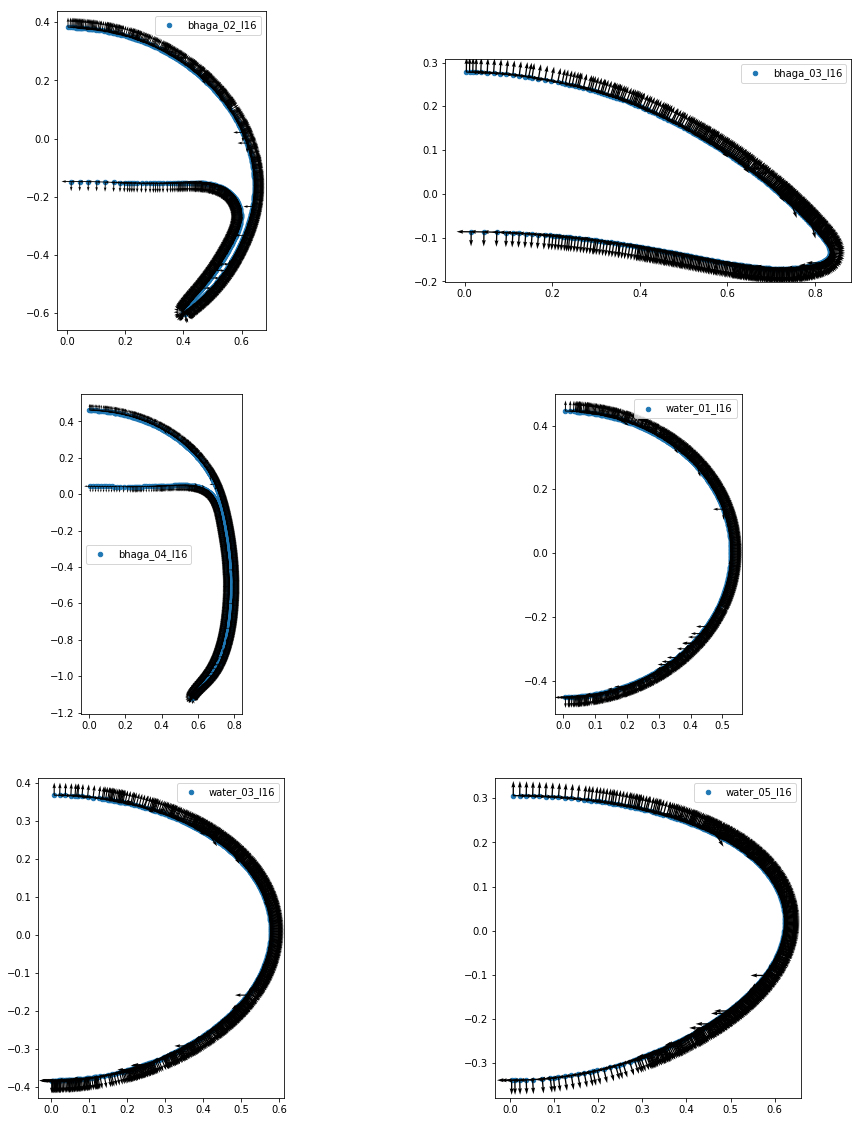

In [3]:
rc('text', usetex=False)
fig, axarr = plt.subplots(3, 2, figsize=(hm.figure_width, 20))

index = [(i,j) for i in range(3) for j in range(2)]

for i, case in enumerate(cases):
    case_name = case.split("/")[-1]
    row, col = index[i]
    c_x, c_y = all_facets[case_name].get_facet_centers(polar=False)
    n_vec = all_facets[case_name].get_unit_normals()
    t_vec = all_facets[case_name].get_unit_tangentials()
    axarr[row, col].scatter(c_x, c_y, s=20, label=case_name)
    axarr[row, col].quiver(c_x, c_y, n_vec[:, 0], n_vec[:, 1], scale=30, units="xy", width=0.003)
    axarr[row, col].quiver(c_x, c_y, t_vec[:, 0], t_vec[:, 1], scale=30, units="xy", width=0.003)
    axarr[row, col].set_aspect("equal")
    axarr[row, col].legend()

Text(0.5,0,'$\\varphi$')

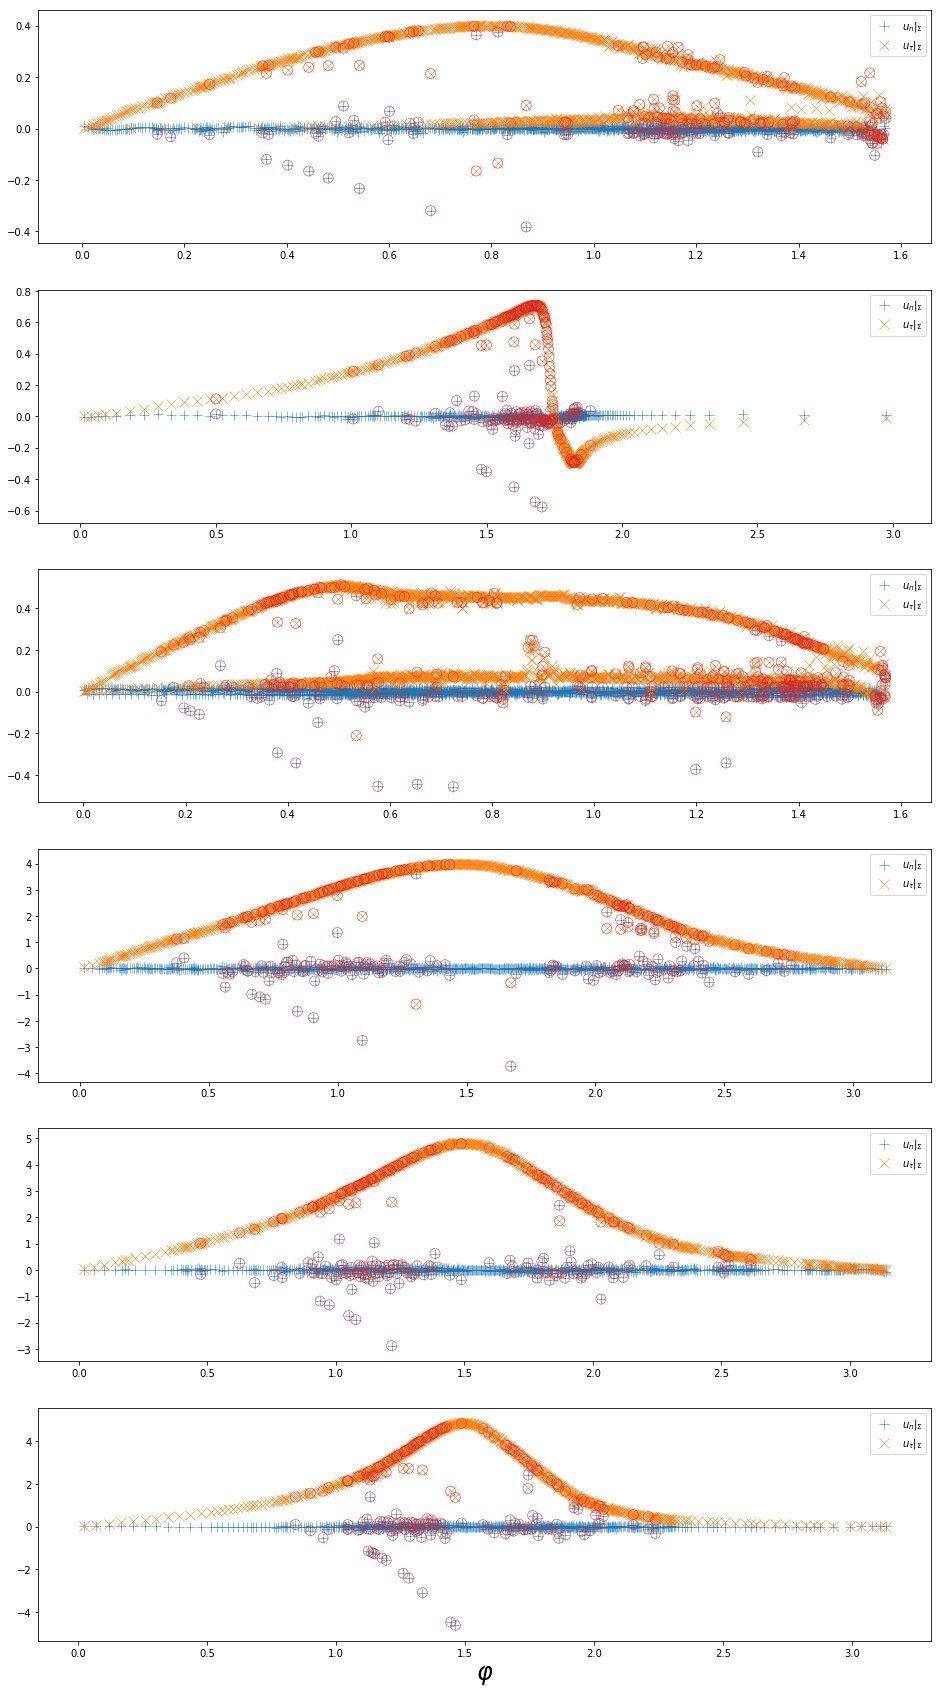

In [4]:
rc('text', usetex=False)
fig, axarr = plt.subplots(6, 1, figsize=(hm.figure_width, 30))

frac = [0.04, 0.02, 0.04, 0.02, 0.02, 0.02]
u_tau_clean = {}
phi_clean = {}
rad_clean = {}

for i, case in enumerate(cases):
    case_name = case.split("/")[-1]
    if case_name in ["bhaga_02_l16", "bhaga_04_l16"]:
        c_x, c_y = all_facets[case_name].get_facet_centers(polar=False)
        p_x, p_y = all_facets[case_name].get_facets(polar=False)
        rad, phi = hm.transform_polar_2D(c_x, c_y + abs(np.min(p_y)))
    else:
        rad, phi = all_facets[case_name].get_facet_centers(polar=True)
    u_n = all_facets[case_name].project_normal(vector=False)
    u_t = all_facets[case_name].project_tangential(vector=False)
    tol = frac[i] * np.max(u_t)
    outliers = np.absolute(u_n) < tol
    u_tau_clean[case_name] = np.asarray([u_t[e] for e in range(u_t.shape[0]) if abs(u_n[e]) < tol])
    phi_clean[case_name] = np.asarray([phi[e] for e in range(phi.shape[0]) if abs(u_n[e]) < tol])
    rad_clean[case_name] = np.asarray([rad[e] for e in range(rad.shape[0]) if abs(u_n[e]) < tol])
    axarr[i].scatter(phi, u_n, c="C0", marker="+", s=100, lw=0.5, label=r"$u_{n}|_\Sigma$")
    axarr[i].scatter(phi, u_t, c="C1", marker="x", s=100, lw=0.5, label=r"$u_{\tau}|_\Sigma$")
    axarr[i].scatter(np.ma.masked_array(phi, mask=outliers), np.ma.masked_array(u_t, mask=outliers),
                     marker="o", facecolors='none', edgecolors='C3', s=100, lw=0.5)
    axarr[i].scatter(np.ma.masked_array(phi, mask=outliers), np.ma.masked_array(u_n, mask=outliers),
                     marker="o", facecolors='none', edgecolors='C3', s=100, lw=0.5)
    axarr[i].legend()
axarr[-1].set_xlabel(r"$\varphi$", fontsize=hm.fontsize_label)

In [5]:
# convinience function for saving plots as png and pdf
def savefig(name):
    path = "../output/"
    plt.savefig(path + name + ".png", bbox_inches="tight")
    plt.savefig(path + name + ".pdf", bbox_inches="tight")

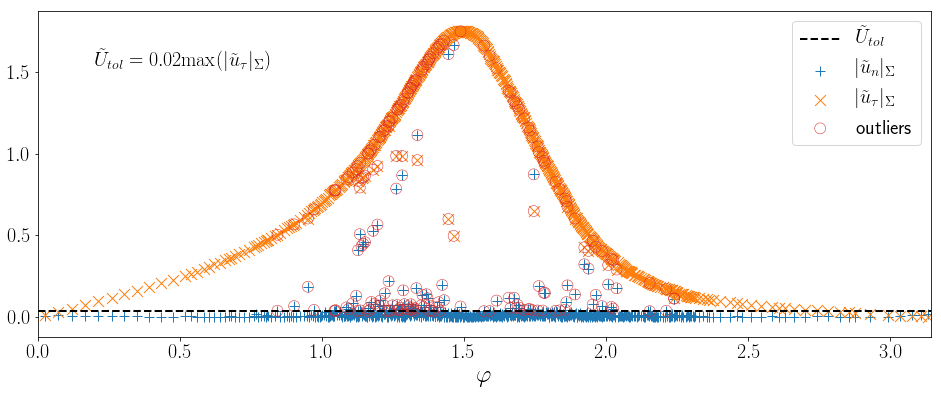

In [6]:
# create examplary figure for thesis
rc('text', usetex=True)
fig, ax = plt.subplots(1, 1, figsize=(hm.figure_width, 6))

case_name = "water_05_l16"
rad, phi = all_facets[case_name].get_facet_centers(polar=True)
u_n = np.absolute(all_facets[case_name].project_normal(vector=False)) / U_b[-1]
u_t = np.absolute(all_facets[case_name].project_tangential(vector=False)) / U_b[-1]
tol = 0.02 * np.max(u_t)
outliers = np.absolute(u_n) < tol
ax.scatter(phi, u_n, c="C0", marker="+", s=120, lw=1.0, label=r"$|\tilde{u}_{n}|_\Sigma$")
ax.scatter(phi, u_t, c="C1", marker="x", s=120, lw=1.0, label=r"$|\tilde{u}_{\tau}|_\Sigma$")
ax.scatter(np.ma.masked_array(phi, mask=outliers), np.ma.masked_array(u_t, mask=outliers),
           marker="o", facecolors='none', edgecolors='C3', s=120, lw=0.5)
ax.scatter(np.ma.masked_array(phi, mask=outliers), np.ma.masked_array(u_n, mask=outliers),
           marker="o", facecolors='none', edgecolors='C3', s=120, lw=0.5, label=r"outliers")
ax.axhline(tol, 0.0, 1.0, ls="--", lw=2, color="k", label=r"$\tilde{U}_{tol}$")

ax.text(0.2, 1.5, r"$\tilde{U}_{tol} = 0.02\mathrm{max}(|\tilde{u}_\tau|_\Sigma)$",
        horizontalalignment='left', verticalalignment='bottom', fontsize=hm.fontsize_legend)
ax.tick_params(labelsize=hm.fontsize_tick)
ax.set_xlabel(r"$\varphi$", fontsize=hm.fontsize_label)
ax.set_xlim(0.0, np.pi)

ax.legend(fontsize=hm.fontsize_legend)
savefig("basilisk_2D_u_sigma_outliers")

## Create models for simple shapes

  0%|          | 3/3000 [00:00<01:57, 25.43it/s]

Minimal loss:  1.19680842293e-05


  0%|          | 2/3000 [00:00<02:44, 18.19it/s]

Minimal loss:  1.50139990344e-05


  0%|          | 5/3000 [00:00<01:13, 40.53it/s]

Minimal loss:  5.08572786885e-06


100%|██████████| 3000/3000 [00:48<00:00, 62.31it/s]


Minimal loss:  3.01057347693e-06


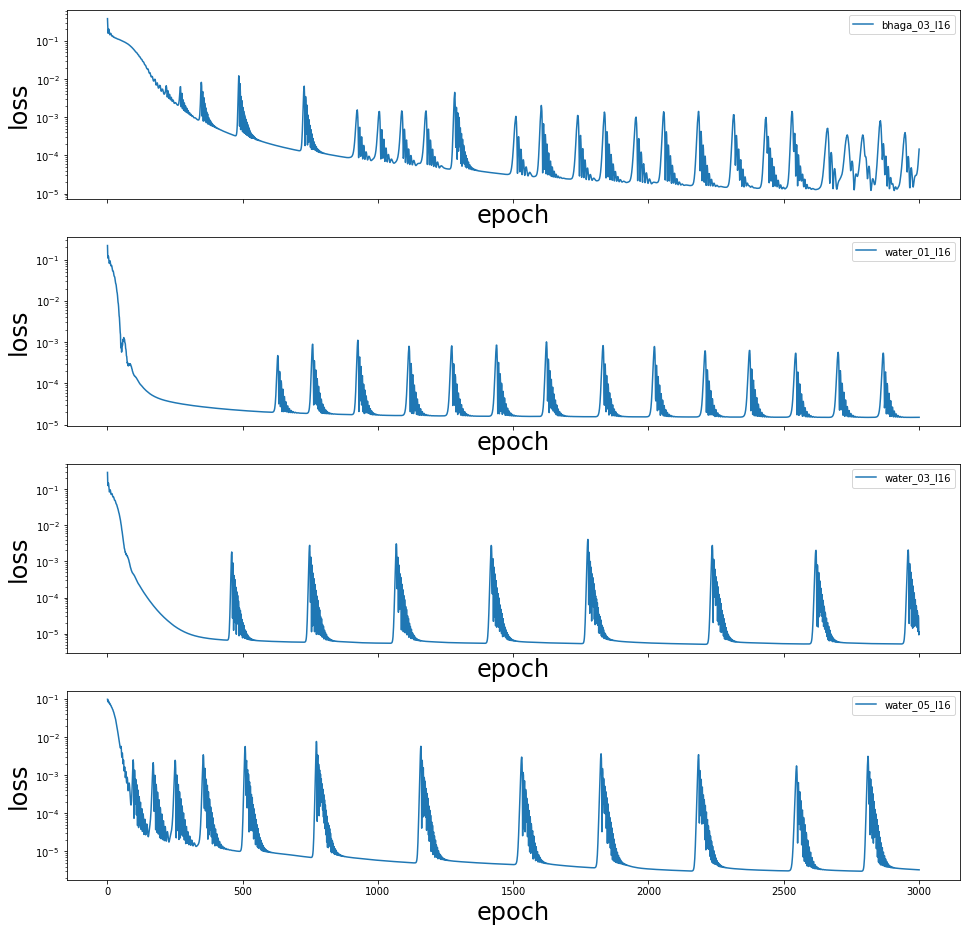

In [7]:
simple_cases = ["bhaga_03_l16", "water_01_l16", "water_03_l16", "water_05_l16"]

rc('text', usetex=False)
fig, axarr = plt.subplots(4, 1, figsize=(hm.figure_width, 16), sharex=True)

model_dict = {
    "n_inputs" : 1,
    "n_outputs" : 1,
    "n_layers" : 4,
    "n_neurons" : 50,
    "activation" : torch.nn.functional.selu,
    "batch_norm" : False
}

model_output = "../output/models/"

epochs = 3000
for i, name in enumerate(simple_cases):
    model = hm.SimpleMLP(**model_dict)
    phi = phi_clean[name]
    phi = np.append(phi, np.asarray([0.0, np.pi]), axis=0)
    u_t = u_tau_clean[name]
    u_t = np.append(u_t, np.asarray([0.0, 0.0]), axis=0)
    weight = np.ones(phi.shape[0])
    weight[-2:] = 2.0
    u_t_norm = (u_t - np.min(u_t)) / (np.max(u_t) - np.min(u_t))
    model_path = model_output + name + "u_t_norm.pt"
    model = hm.SimpleMLP(**model_dict)
    model, losses = hm.training_loop(model, model_path, phi, u_t_norm, weight, epochs, 0.001)
    print("Minimal loss: ", np.min(losses))
    axarr[i].plot(range(1, epochs+1), losses, label=name)
    axarr[i].set_xlabel("epoch", fontsize=hm.fontsize_label)
    axarr[i].set_ylabel("loss", fontsize=hm.fontsize_label)
    axarr[i].set_yscale('log')
    axarr[i].legend()

values at phi = 0 / pi
-0.002008778192  /  -0.000853725259774
0.0205658395168  /  0.0142442829317
0.00988973447567  /  0.00896589889765
0.00902478904294  /  0.0225363703324


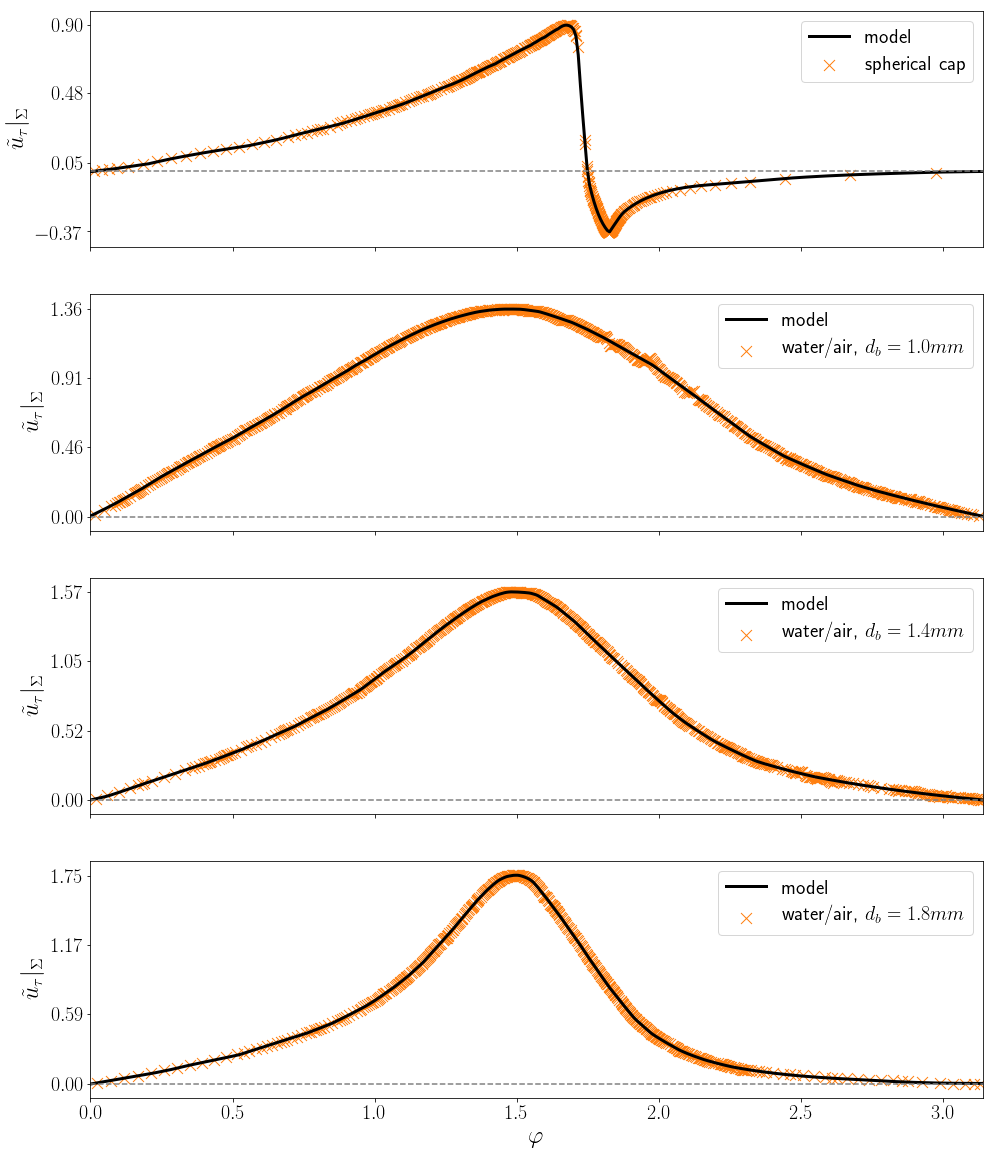

In [8]:
rc('text', usetex=True)
fig, axarr = plt.subplots(4, 1, figsize=(hm.figure_width, 20), sharex=True)
U_b_simple = [U_b[1]] + U_b[3:]
labels = [r"spherical cap", r"water/air, $d_b=1.0mm$", r"water/air, $d_b=1.4mm$", r"water/air, $d_b=1.8mm$"]

phi_eval = torch.from_numpy(np.linspace(0.0, np.pi, 400)).unsqueeze(-1)
print("values at phi = 0 / pi")
for i, name in enumerate(simple_cases):
    model = hm.SimpleMLP(**model_dict)
    model_path = model_output + name + "u_t_norm.pt"
    model.load_state_dict(torch.load(model_path))
    model.eval()
    u_t = u_tau_clean[name]
    u_model = model.forward(phi_eval).detach().squeeze().numpy()
    u_model = u_model * (np.max(u_t) - np.min(u_t)) + np.min(u_t)
    print(u_model[0], " / ", u_model[-1])
    
    axarr[i].scatter(phi_clean[name], u_tau_clean[name] / U_b_simple[i], c="C1", marker="x", s=120, lw=1.0,
                     label=labels[i])
    axarr[i].plot(phi_eval, u_model / U_b_simple[i], c="k", lw=hm.line_width, label="model")
    
    u_t_max = np.max(u_model / U_b_simple[i])
    u_t_min = np.min(u_model / U_b_simple[i])
    axarr[i].set_yticks(np.around(np.linspace(u_t_min, u_t_max, 4), 2))
    axarr[i].tick_params(labelsize=hm.fontsize_tick)
    axarr[i].set_xlim(0.0, np.pi)
    axarr[i].set_ylabel(r"$\tilde{u}_{\tau}|_\Sigma$", fontsize=hm.fontsize_label)
    axarr[i].legend(fontsize=hm.fontsize_legend)
    axarr[i].axhline(0.0, 0.0, 1.0, ls="--", color="gray")
axarr[-1].set_xlabel(r"$\varphi$", fontsize=hm.fontsize_label)
savefig("basilisk_2D_u_t_simple")

## Create models for complex shapes

In [9]:
def split_inner_outer(name, phi, rad, u_t):
    phi_tensor = torch.from_numpy(phi.astype(np.float64)).unsqueeze(-1)
    model_path = "../output/models/" + name + "_inout_ts.pt"
    model = torch.jit.load(model_path)
    rad_inout = model.forward(phi_tensor).detach().numpy()
    inner_dist = np.absolute(rad - rad_inout[:, 0])
    outer_dist = np.absolute(rad - rad_inout[:, 1])
    inner_cont = inner_dist < outer_dist
    outer_cont = outer_dist < inner_dist
    return phi[inner_cont], u_t[inner_cont], phi[outer_cont], u_t[outer_cont]

  0%|          | 3/2000 [00:00<01:11, 27.74it/s]

Minimal loss (inner):  0.00632797575609


  0%|          | 0/2000 [00:00<?, ?it/s]

Minimal loss (outer):  0.000410759156764


  0%|          | 4/2000 [00:00<01:01, 32.69it/s]

Minimal loss (inner):  0.00446520427428


100%|██████████| 2000/2000 [00:44<00:00, 44.60it/s]


Minimal loss (outer):  0.000478315259734


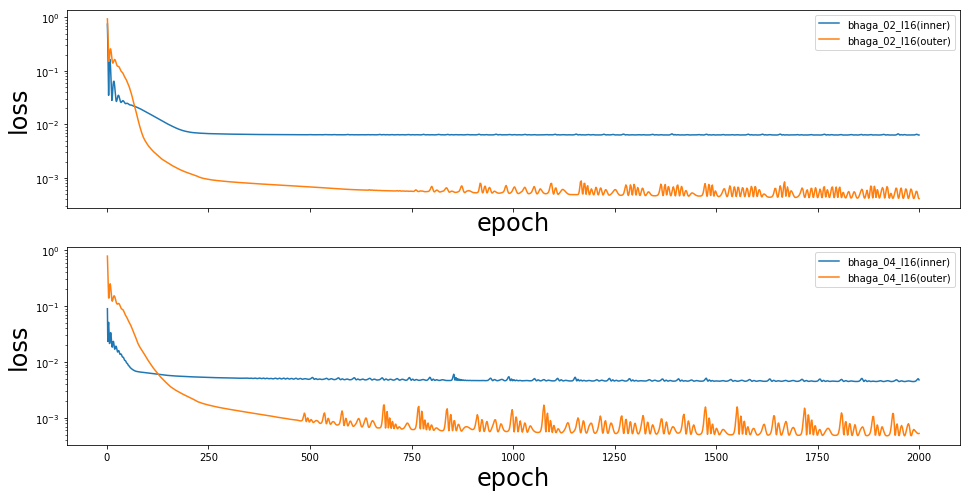

In [10]:
complex_cases = ["bhaga_02_l16", "bhaga_04_l16"]

rc('text', usetex=False)
fig, axarr = plt.subplots(2, 1, figsize=(hm.figure_width, 8), sharex=True)

model_dict = {
    "n_inputs" : 1,
    "n_outputs" : 1,
    "n_layers" : 4,
    "n_neurons" : 50,
    "activation" : torch.nn.functional.selu,
    "batch_norm" : False
}

model_output = "../output/models/"

epochs = 2000
for i, name in enumerate(complex_cases):
    phi_in, u_t_in, phi_out, u_t_out = split_inner_outer(name, phi_clean[name], rad_clean[name], u_tau_clean[name])
    phi_in = np.append(phi_in, np.asarray([0.0, 0.5 * np.pi]), axis=0)
    u_t_in = np.append(u_t_in, np.asarray([0.0, 0.0]), axis=0)
    phi_out = np.append(phi_out, np.asarray([0.0, 0.5 * np.pi]), axis=0)
    u_t_out = np.append(u_t_out, np.asarray([0.0, 0.0]), axis=0)
    weight_in = np.where(phi_in > 0.47 * np.pi, 2.0, 1.0)
    weight_in[-2:] = 10.0
    weight_out = np.ones(phi_out.shape[0])
    weight_out[-2:] = 10.0
    u_in_norm = (u_t_in - np.min(u_t_in)) / (np.max(u_t_in) - np.min(u_t_in))
    u_out_norm = (u_t_out - np.min(u_t_out)) / (np.max(u_t_out) - np.min(u_t_out))
    model = hm.SimpleMLP(**model_dict)
    model_path = model_output + name + "u_t_inner_norm.pt"
    model, losses = hm.training_loop(model, model_path, phi_in, u_in_norm, weight_in, epochs, 0.001)
    print("Minimal loss (inner): ", np.min(losses))
    axarr[i].plot(range(1, epochs+1), losses, label=name + "(inner)")
    model = hm.SimpleMLP(**model_dict)
    model_path = model_output + name + "u_t_outer_norm.pt"
    model, losses = hm.training_loop(model, model_path, phi_out, u_out_norm, weight_out, epochs, 0.001)
    print("Minimal loss (outer): ", np.min(losses))
    axarr[i].plot(range(1, epochs+1), losses, label=name + "(outer)")
    axarr[i].set_xlabel("epoch", fontsize=hm.fontsize_label)
    axarr[i].set_ylabel("loss", fontsize=hm.fontsize_label)
    axarr[i].set_yscale('log')
    axarr[i].legend()

values at phi = 0 / pi
7.05802083916e-05  /  0.00038963421933
0.0035169303431  /  0.0100242693863

0.000321650548725  /  -0.00434672027175
0.00284417650496  /  0.00900832295832



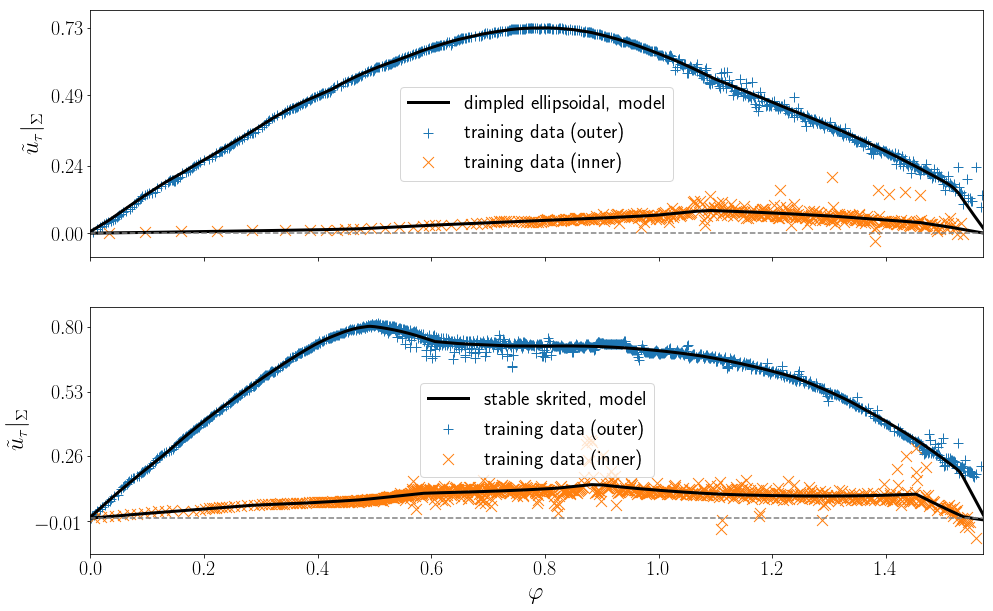

In [11]:
rc('text', usetex=True)
fig, axarr = plt.subplots(2, 1, figsize=(hm.figure_width, 10), sharex=True)
U_b_complex = [U_b[0], U_b[2]]
labels = [r"dimpled ellipsoidal", r"stable skrited"]

phi_eval = torch.from_numpy(np.linspace(0.0, 0.5*np.pi, 400)).unsqueeze(-1)
print("values at phi = 0 / pi")
for i, name in enumerate(complex_cases):
    phi_in, u_t_in, phi_out, u_t_out = split_inner_outer(name, phi_clean[name], rad_clean[name], u_tau_clean[name])
    model = hm.SimpleMLP(**model_dict)
    # inner contour
    model_path = model_output + name + "u_t_inner_norm.pt"
    model.load_state_dict(torch.load(model_path))
    u_in_model = model.forward(phi_eval).detach().squeeze().numpy()
    u_in_model = u_in_model * (np.max(u_t_in) - np.min(u_t_in)) + np.min(u_t_in)
    # outer contour
    model_path = model_output + name + "u_t_outer_norm.pt"
    model.load_state_dict(torch.load(model_path))
    u_out_model = model.forward(phi_eval).detach().squeeze().numpy()
    u_out_model = u_out_model * (np.max(u_t_out) - np.min(u_t_out)) + np.min(u_t_out)
    print(u_in_model[0], " / ", u_in_model[-1])
    print(u_out_model[0], " / ", u_out_model[-1])
    print("")
    
    axarr[i].scatter(phi_out, u_t_out / U_b_complex[i], c="C0", marker="+", s=120, lw=1.0,
                     label="training data (outer)")
    axarr[i].scatter(phi_in, u_t_in / U_b_complex[i], c="C1", marker="x", s=120, lw=1.0,
                     label="training data (inner)")
    axarr[i].plot(phi_eval, u_in_model / U_b_complex[i], c="k", lw=hm.line_width, label=labels[i] + ", model")
    axarr[i].plot(phi_eval, u_out_model / U_b_complex[i], c="k", lw=hm.line_width)
    axarr[i].axhline(0.0, 0.0, 1.0, ls="--", color="gray")
    
    u_t_max = np.max(u_out_model / U_b_complex[i])
    u_t_min = np.min(u_in_model / U_b_complex[i])
    axarr[i].set_yticks(np.around(np.linspace(u_t_min, u_t_max, 4), 2))
    axarr[i].tick_params(labelsize=hm.fontsize_tick)
    axarr[i].set_xlim(0.0, 0.5*np.pi)
    axarr[i].set_ylabel(r"$\tilde{u}_{\tau}|_\Sigma$", fontsize=hm.fontsize_label)
    axarr[i].legend(fontsize=hm.fontsize_legend)
    
axarr[-1].set_xlabel(r"$\varphi$", fontsize=hm.fontsize_label)
savefig("basilisk_2D_u_t_complex")

In [12]:
class FinalVelocityModelSimple(torch.nn.Module):
    def __init__(self, model, u_min, u_max):
        super().__init__()
        self.model = model
        self.u_min = torch.tensor(u_min, dtype=torch.float64)
        self.u_max = torch.tensor(u_max, dtype=torch.float64)
        
    def forward(self, X):
        u = self.model.forward(X)
        u = u * (self.u_max - self.u_min) + self.u_min
        return u.squeeze()

class FinalVelocityModelComplex(torch.nn.Module):
    def __init__(self, model_in, u_in_min, u_in_max, model_out, u_out_min, u_out_max):
        super().__init__()
        self.model_in = model_in
        self.u_in_min = torch.tensor(u_in_min, dtype=torch.float64)
        self.u_in_max = torch.tensor(u_in_max, dtype=torch.float64)
        self.model_out = model_out
        self.u_out_min = torch.tensor(u_out_min, dtype=torch.float64)
        self.u_out_max = torch.tensor(u_out_max, dtype=torch.float64)
        
    def forward(self, X):
        u_in = self.model_in.forward(X)
        u_out = self.model_out.forward(X)
        u_in = u_in * (self.u_in_max - self.u_in_min) + self.u_in_min
        u_out = u_out * (self.u_out_max - self.u_out_min) + self.u_out_min
        return torch.stack((u_in, u_out)).T.squeeze()

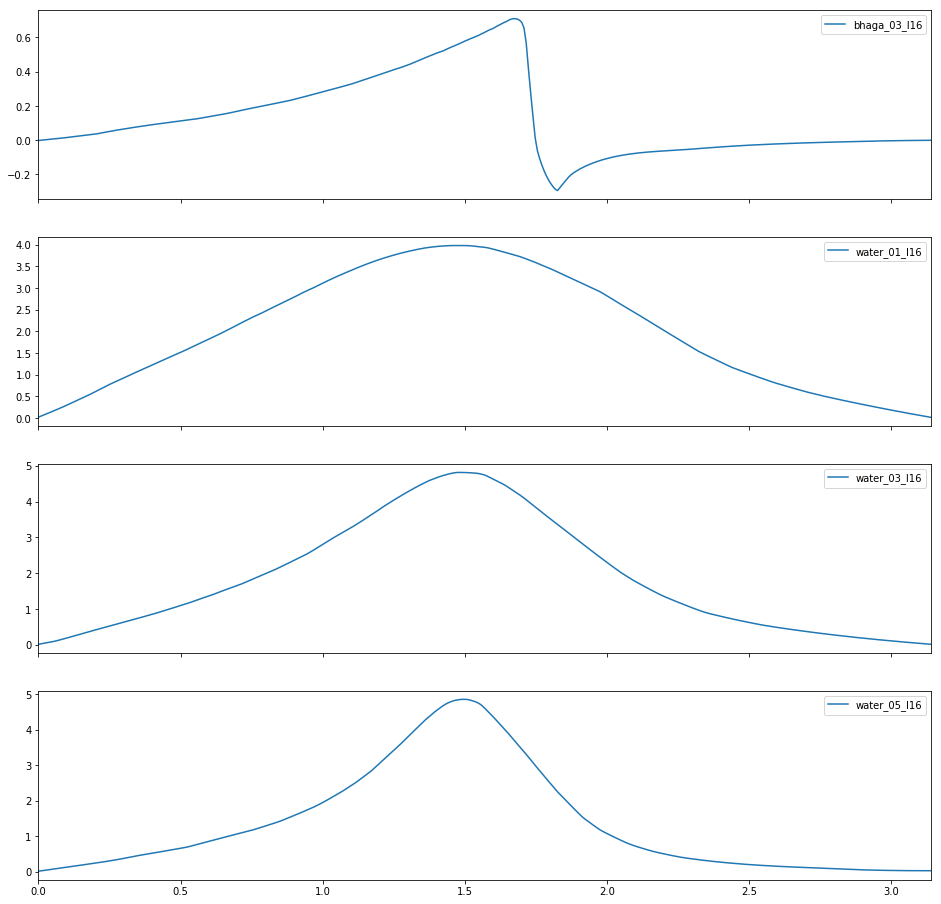

In [13]:
rc('text', usetex=False)
fig, axarr = plt.subplots(4, 1, figsize=(hm.figure_width, 16), sharex=True)

phi_eval = torch.from_numpy(np.linspace(0.0, np.pi, 400)).unsqueeze(-1)

for i, name in enumerate(simple_cases):
    model = hm.SimpleMLP(**model_dict)
    model_path = model_output + name + "u_t_norm.pt"
    model.load_state_dict(torch.load(model_path))
    u_t = u_tau_clean[name]
    full_model = FinalVelocityModelSimple(model, np.min(u_t), np.max(u_t))
    u_model = full_model.forward(phi_eval)
    axarr[i].plot(phi_eval.detach(), u_model.detach(), label=name)
    axarr[i].set_xlim(0.0, np.pi)
    axarr[i].legend()
    # trace and save
    model_trace = torch.jit.trace(full_model, phi_eval[0])
    model_trace.save(model_output + name + "_u_tau_ts.pt")

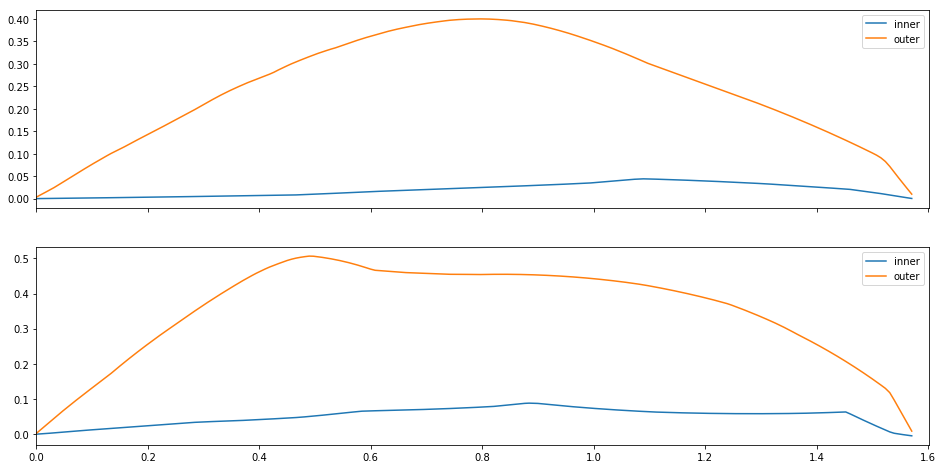

In [14]:
rc('text', usetex=False)
fig, axarr = plt.subplots(2, 1, figsize=(hm.figure_width, 8), sharex=True)

phi_eval = torch.from_numpy(np.linspace(0.0, 0.5 * np.pi, 200)).unsqueeze(-1)

for i, name in enumerate(complex_cases):
    phi_in, u_t_in, phi_out, u_t_out = split_inner_outer(name, phi_clean[name], rad_clean[name], u_tau_clean[name])
    model_in = hm.SimpleMLP(**model_dict)
    model_path = model_output + name + "u_t_inner_norm.pt"
    model_in.load_state_dict(torch.load(model_path))
    model_out = hm.SimpleMLP(**model_dict)
    model_path = model_output + name + "u_t_outer_norm.pt"
    model_out.load_state_dict(torch.load(model_path))
    full_model = FinalVelocityModelComplex(model_in, np.min(u_t_in), np.max(u_t_in),
                                           model_out, np.min(u_t_out), np.max(u_t_out))
    u_model = full_model.forward(phi_eval)
    axarr[i].plot(phi_eval.detach(), u_model[:, 0].detach(), label="inner")
    axarr[i].plot(phi_eval.detach(), u_model[:, 1].detach(), label="outer")
    axarr[i].set_xlim(0.0, 0.51 * np.pi)
    axarr[i].legend()
    # trace and save
    model_trace = torch.jit.trace(full_model, phi_eval[0])
    model_trace.save(model_output + name + "_u_tau_ts.pt")